In [3]:
# imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
# use a list of the NasDAQ-100 companies
nasdaq100_tickers = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMD", "AMAT", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "PEP", "PLTR", "PYPL", "QCOM", "REGN", "ROP",
    "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", "TXN",
    "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]

# load eveyrthing into seperate csv files
directory = "nasdaq100_data"
if not os.path.exists(directory):
    os.makedirs(directory)

for ticker in nasdaq100_tickers:
    csv_path = os.path.join(directory, f"{ticker}.csv")
    if os.path.exists(csv_path):
        continue
    data = yf.Ticker(ticker).history(start='2010-01-01', end='2024-10-31')
    data.to_csv(csv_path)


In [43]:
holder = {}

for symbol in nasdaq100_tickers:
    csv_path = os.path.join(directory, f"{symbol}.csv")
    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(
        csv_path,
        parse_dates=["Date"],
        index_col="Date",
        usecols=["Date", "Open", "Close"]
    )

    # Force index to datetime (handles string/mixed indexes)
    df.index = pd.to_datetime(df.index, errors="coerce")

    # Drop bad rows (unparseable dates)
    df = df[~df.index.isna()]

    # If tz-aware, remove timezone
    if isinstance(df.index, pd.DatetimeIndex) and df.index.tz is not None:
        df.index = df.index.tz_localize(None)

    # Sort for clean slicing
    df = df.sort_index()

    holder[symbol] = df


In [44]:
holder["AAPL"].head() 

,Open,Close
Date,,
2010-01-04,6.400987,6.418382
2010-01-05,6.436077,6.429479
2010-01-06,6.429479,6.327210
2010-01-07,6.350602,6.315512
2010-01-08,6.307116,6.357501


In [45]:
def compute_polynomial_bands(df, degree=4, window=60, k=2):
    df['Poly_Center'] = np.nan
    df['Upper_Band'] = np.nan
    df['Lower_Band'] = np.nan

    closes = df['Close'].values

    for i in range(window, len(df)):
        # closing values up to i-1
        y = closes[i-window:i]
        # numbered x values from 0 - (window-1)
        x = np.arange(window)

        # fit polynomial based on degree
        coeffs = np.polyfit(x, y, degree)
        # create polynomial function based on coefficients
        poly = np.poly1d(coeffs)

        # calculate fitted values and error for each data point to find sigma
        fitted_window = poly(x)
        error = y - fitted_window

        sigma = np.sqrt(np.mean(error**2))

        # now calculate the center value at the window-th point
        center = poly(window)

        idx = df.index[i]
        df.at[idx, 'Poly_Center'] = center
        df.at[idx, 'Upper_Band'] = center + k * sigma
        df.at[idx, 'Lower_Band'] = center - k * sigma
    return df


# Example usage
test = compute_polynomial_bands(holder["AAPL"].copy())
test.tail()


,Open,Close,Poly_Center,Upper_Band,Lower_Band
Date,,,,,
2024-03-04,174.724658,173.683167,174.175256,180.922177,167.428335
2024-03-05,169.378290,168.743469,172.389929,179.102831,165.677028
2024-03-06,169.675877,167.751572,169.401077,176.040673,162.761480
2024-03-07,167.781318,167.632538,166.865844,173.427042,160.304646
2024-03-08,167.632529,169.348526,165.082480,171.581442,158.583517


In [46]:
def assign_signals(df):
    df = df.copy()
    df["Signal"] = np.nan

    # Exit when breakout above upper band
    df.loc[df["Close"] > df["Upper_Band"], "Signal"] = 0

    # Enter flat when breakdown below lower band
    df.loc[df["Close"] < df["Lower_Band"], "Signal"] = 1

    return df

def assign_positions(df):
    df = df.copy()

    df["Position"] = df["Signal"].ffill().fillna(0)
    df["Position"] = df["Position"].shift(1).fillna(0)

    return df


In [47]:
def apply_strategy(df, investment=10000):
    df = df.copy()
    df["Daily_Return"] = df["Close"].pct_change().fillna(0)
    df["Strategy_Return"] = df["Daily_Return"] * df["Position"]
    df["Strategy_Portfolio_Value"] = investment * (1 + df["Strategy_Return"].cumsum())
    return df

def simple_strategy(df, investment=10000):
    df = df.copy()
    df["Simple_Portfolio_Value"] = investment * (1 + df["Daily_Return"].cumsum())
    return df

In [48]:
holder_signals = {}

for symbol in nasdaq100_tickers:
    df = holder[symbol]
    df = compute_polynomial_bands(df)
    df = assign_signals(df)
    df = assign_positions(df)
    df = apply_strategy(df, 10000)
    df = simple_strategy(df, 10000)
    holder_signals[symbol] = df

In [49]:
holder_signals["AAPL"].tail()

,Open,Close,Poly_Center,Upper_Band,Lower_Band,Signal,Position,Daily_Return,Strategy_Return,Strategy_Portfolio_Value,Simple_Portfolio_Value
Date,,,,,,,,,,,
2024-03-04,174.724658,173.683167,174.175256,180.922177,167.428335,NaN,0.0,-0.025381,-0.0,23943.185047,49628.074793
2024-03-05,169.378290,168.743469,172.389929,179.102831,165.677028,NaN,0.0,-0.028441,-0.0,23943.185047,49343.666271
2024-03-06,169.675877,167.751572,169.401077,176.040673,162.761480,NaN,0.0,-0.005878,-0.0,23943.185047,49284.884880
2024-03-07,167.781318,167.632538,166.865844,173.427042,160.304646,NaN,0.0,-0.000710,-0.0,23943.185047,49277.789041
2024-03-08,167.632529,169.348526,165.082480,171.581442,158.583517,NaN,0.0,0.010237,0.0,23943.185047,49380.155096


In [50]:
# find the highest portfolio value at the end of the period
final_values = {}
for symbol, df in holder_signals.items():
    final_portfolio_value = df["Strategy_Portfolio_Value"].iloc[-1]
    final_values[symbol] = final_portfolio_value

# sort by final portfolio value
sorted_final_values = sorted(final_values.items(), key=lambda x: x[1], reverse=True)
print("Top 5 Performing Stocks with Polynomial Band Strategy:")
for symbol, value in sorted_final_values[:5]:
    print(f"{symbol}: ${value:.2f}, Simple Investment: ${holder_signals[symbol]['Simple_Portfolio_Value'].iloc[-1]:.2f}")

Top 5 Performing Stocks with Polynomial Band Strategy:
TSLA: $49534.37, Simple Investment: $84616.80
META: $43068.06, Simple Investment: $51160.09
AXON: $37678.53, Simple Investment: $69281.12
SHOP: $33071.67, Simple Investment: $69340.77
AVGO: $32943.14, Simple Investment: $62397.96


In [51]:
# are there any stocks where the strategy beat simple investment?
print("\nStocks where Polynomial Band Strategy outperformed Simple Investment:")
for symbol, df in holder_signals.items():
    if df["Strategy_Portfolio_Value"].iloc[-1] > df["Simple_Portfolio_Value"].iloc[-1]:
        print(f"{symbol}: Strategy ${df['Strategy_Portfolio_Value'].iloc[-1]:.2f} vs Simple ${df['Simple_Portfolio_Value'].iloc[-1]:.2f}")


Stocks where Polynomial Band Strategy outperformed Simple Investment:
BIIB: Strategy $31748.56 vs Simple $31477.94
GFS: Strategy $14012.72 vs Simple $10532.43


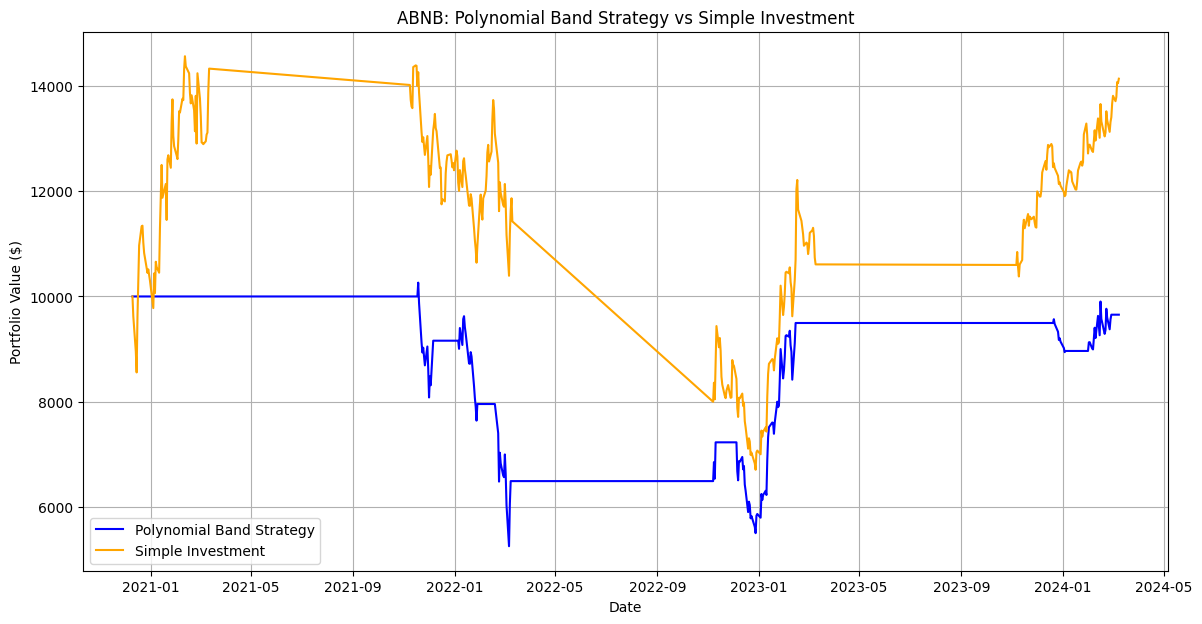

In [52]:
# Only ABNB outperformed simple investment in this case. 
# Plotting the results for ABNB
abnb_df = holder_signals["ABNB"]
plt.figure(figsize=(14, 7))
plt.plot(abnb_df.index, abnb_df["Strategy_Portfolio_Value"], label="Polynomial Band Strategy", color='blue')
plt.plot(abnb_df.index, abnb_df["Simple_Portfolio_Value"], label="Simple Investment", color='orange')
plt.title("ABNB: Polynomial Band Strategy vs Simple Investment")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

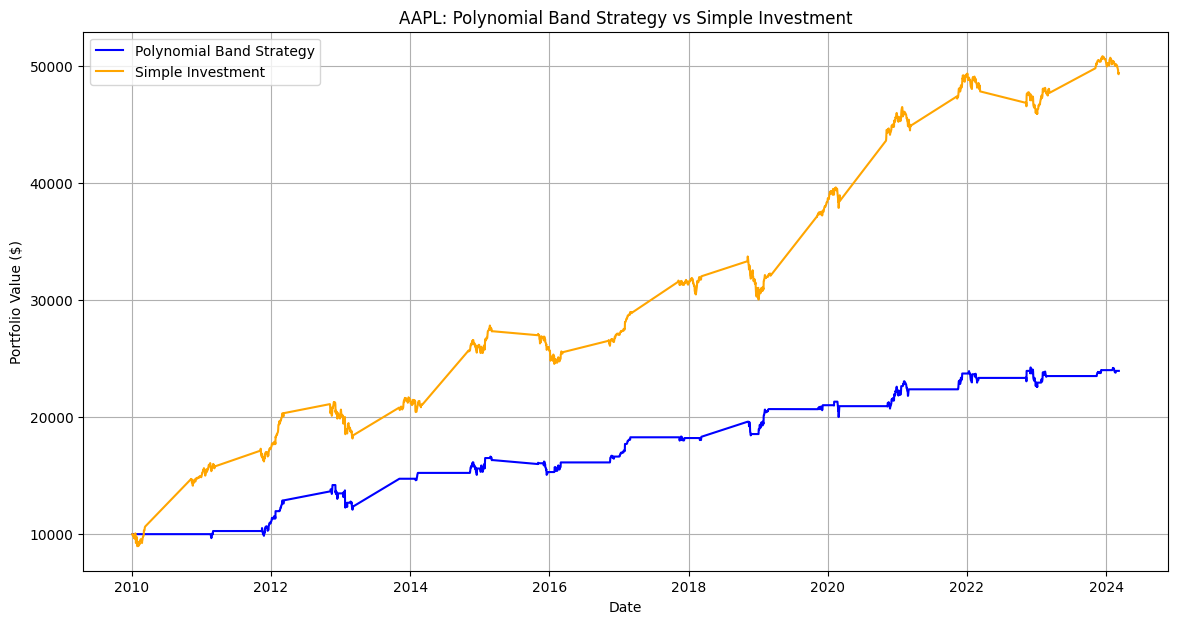

In [53]:
# analyze AAPL as well
aapl_df = holder_signals["AAPL"]
plt.figure(figsize=(14, 7))
plt.plot(aapl_df.index, aapl_df["Strategy_Portfolio_Value"], label="Polynomial Band Strategy", color='blue')
plt.plot(aapl_df.index, aapl_df["Simple_Portfolio_Value"], label="Simple Investment", color='orange')
plt.title("AAPL: Polynomial Band Strategy vs Simple Investment")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

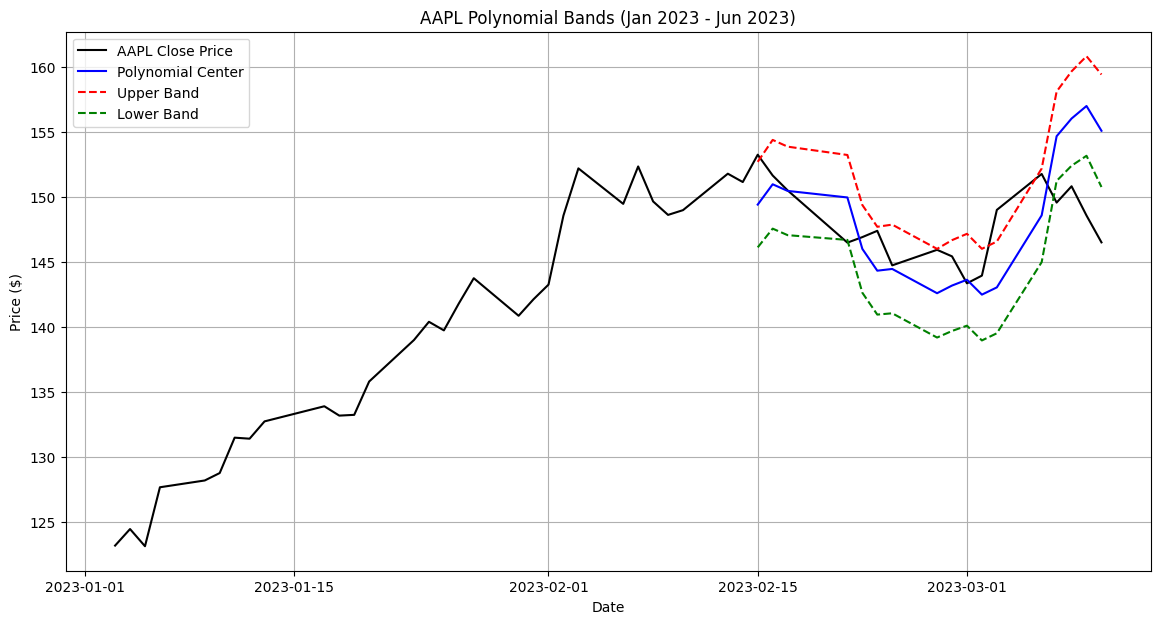

In [55]:
# lets look at a polynomial fit on AAPL, but on one 6 month period
aapl_sample = holder["AAPL"].loc['2023-01-01':'2023-06-30'].copy()
aapl_sample = compute_polynomial_bands(aapl_sample, degree=4, window=30, k=2)
plt.figure(figsize=(14, 7))
plt.plot(aapl_sample.index, aapl_sample["Close"], label="AAPL Close Price", color='black')
plt.plot(aapl_sample.index, aapl_sample["Poly_Center"], label="Polynomial Center", color='blue')
plt.plot(aapl_sample.index, aapl_sample["Upper_Band"], label="Upper Band", color='red', linestyle='--')
plt.plot(aapl_sample.index, aapl_sample["Lower_Band"], label="Lower Band", color='green', linestyle='--')
plt.title("AAPL Polynomial Bands (Jan 2023 - Jun 2023)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()